### Imports

In [840]:
from PIL import Image, ImageEnhance, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from copy import copy
import os
np.set_printoptions(linewidth = 200)
%matplotlib inline 

### Global variables

In [841]:
input_dir = 'input/'
output_dir = 'output/'
# Pixels per character cut
SIZE = 30
# Remove 2 pixels from each edge to remove lines. 
CROP_SIZE = 26
# Pixels per new character image
NEW_SIZE = 28
# Dictionary of alefbet with sofit forms.
ALEFBET = {
    "alef" : [], 
    "bet" : [],
    "gimel" : [],
    "dalet" : [],
    "he" : [],
    "vav" : [],
    "zayin" : [],
    "chet" : [],
    "tet" : [],
    "yod" : [],
    "kaf" : [],
    "kaf_sof" : [],
    "lamed" : [],
    "mem" : [],
    "mem_sof" : [],
    "nun" : [],
    "nun_sof" : [],
    "samech" : [],
    "ayin" : [],
    "pe" : [],
    "pe_sof" : [],
    "tsadik" : [],
    "tsadik_sof" : [],
    "qof" : [],
    "resh" : [],
    "sin" : [],
    "shin" : [],
    "tav" : [],
}

### Functions to convert image to individual characters

In [842]:
# Load all images from out input directory.
def get_imgs(img_dir):
    input_imgs = [os.path.join(img_dir,f) for f in os.listdir(img_dir)]
    return input_imgs

# Convert the images to black and white. 
def imgs_to_bw(imgs):
    bw_imgs = []
    for img in imgs:
        image = Image.open(img)
        bw_img = image.convert(mode='L')
        # Increase contrast to have letters show up better. 
        bw_img = ImageEnhance.Contrast(bw_img).enhance(1.5)
        bw_imgs.append(bw_img)
    return bw_imgs
    
# Cut square images, SIZExSIZE pixels each. 
def img_to_alefbet(img):
    alefbet = ALEFBET.copy()
    for i, y in enumerate(range(0, img.height, SIZE)):
        cuts=[]
        for x in range(0, img.width, SIZE):
            cut = img.crop(box=(x, y, x+SIZE, y+SIZE))
            cuts.append(cut)
        key_at_i = list(alefbet.keys())[i]
        alefbet[key_at_i] = cuts
    return alefbet

def crop_center(pil_img, crop_width=CROP_SIZE, crop_height=CROP_SIZE):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

# In order to find and fix its location, I have to invert pixels, so that 
# background area becomes black, and filled with zero pixels. Then `getbbox` 
# method gives us the digit location, which has to be centered.
def resize_chars(alefbet):
    for key in alefbet:
        resized_chars = []
        for char in alefbet[key]:
            inv_sample = ImageOps.invert(char)
            inv_sample = crop_center(inv_sample)
            bbox = inv_sample.getbbox()
            crop = inv_sample.crop(bbox)
            # Resize back
            delta_w = NEW_SIZE - crop.size[0]
            delta_h = NEW_SIZE - crop.size[1]
            padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
            new_img = ImageOps.expand(crop, padding)
            resized_chars.append(new_img)
        alefbet[key] = resized_chars
    return alefbet

### Functions to save the new character images

In [843]:
# Make a dir for each letter of alefbet
def make_dirs(output_dir):
    img_paths = []
    os.makedirs(output_dir, exist_ok=True)
    for char_name in ALEFBET:
        path = os.path.join(output_dir, char_name)
        os.makedirs(path, exist_ok=True)
        img_paths.append(path)

# Save char data from alefbet to respective char folders
def save_data(data, output_dir):
    for i, alefbet in enumerate(data):
        base = i*5
        for key in alefbet:
            char_dir = os.path.join(output_dir, key)
            for j, char_img in enumerate(alefbet[key]):
                img_path = os.path.join(char_dir, f"{(j+1) + base}.png")
                img = char_img.save(img_path)

# Convert folder of input images to labeled alefbet directory
def process_data(input_dir, output_dir):
    data = []
    input_imgs = get_imgs(input_dir)
    bw_imgs = imgs_to_bw(input_imgs)
    for img in bw_imgs:
        alefbet = img_to_alefbet(img)
        alefbet = resize_chars(alefbet)
        data.append(alefbet)
    make_dirs(output_dir)
    save_data(data, output_dir)

### Save the image data locally

In [844]:
process_data(input_dir, output_dir)

### Save the result in numpy binary format

`Image.getdata()` method returns image bytes, which we put into numpy array.

In [845]:
# Read in the data from the saved output directory
cleaned_samples = []
char_dirs = [os.path.join(output_dir, d) for d in os.listdir(output_dir)]
for char_dir in char_dirs:
    char_samples = [os.path.join(char_dir, char) for char in os.listdir(char_dir)]
    cleaned_samples.append(sorted(char_samples))

cleaned_samples.sort()
for i, chars in enumerate(cleaned_samples):
    for j, char in enumerate(chars):
        cleaned_samples[i][j] = Image.open(char)

In [846]:
binary_samples = np.array([[sample.getdata() for sample in row] for row in cleaned_samples])
binary_samples = binary_samples.reshape(len(cleaned_samples)*len(cleaned_samples[0]), NEW_SIZE, NEW_SIZE)
classes = np.array([[i]*len(cleaned_samples[0]) for i in range(NEW_SIZE)]).reshape(-1)

In [847]:
print(f'X shape: {binary_samples.shape}')
print(f'y shape: {classes.shape}')

X shape: (3220, 28, 28)
y shape: (3220,)


Save files to numpy binary format...

In [848]:
xfile = 'digits_x_test.npy'
yfile = 'digits_y_test.npy'
np.save(xfile, binary_samples)
np.save(yfile, classes)

### Create Train and Test Sets

In [849]:
from sklearn.model_selection import train_test_split
x_test = np.load(xfile)
y_test = np.load(yfile)
x_test.shape, y_test.shape

class_names = list(ALEFBET.keys())
class_names.sort()

# Splite the dataset. 
train_images, test_images, train_labels, test_labels =\
    train_test_split(x_test, y_test, test_size=0.3)

# Convert color values to 0-1 scale. 
train_images = train_images / 255.0
test_images = test_images / 255.0

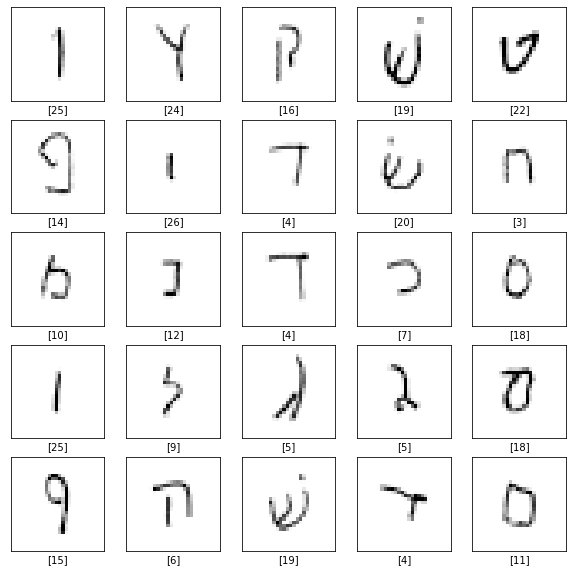

In [850]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel([train_labels[i]])
plt.show()

### Train Neural Network

In [851]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(28)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
71/71 [==============================] - 0s 2ms/step - loss: 2.8996 - accuracy: 0.3217
Epoch 2/10
71/71 [==============================] - 0s 3ms/step - loss: 1.8709 - accuracy: 0.6282
Epoch 3/10
71/71 [==============================] - 0s 2ms/step - loss: 1.3083 - accuracy: 0.7249
Epoch 4/10
71/71 [==============================] - 0s 2ms/step - loss: 1.0297 - accuracy: 0.7786
Epoch 5/10
71/71 [==============================] - 0s 2ms/step - loss: 0.8560 - accuracy: 0.8101
Epoch 6/10
71/71 [==============================] - 0s 2ms/step - loss: 0.7409 - accuracy: 0.8341
Epoch 7/10
71/71 [==============================] - 0s 2ms/step - loss: 0.6593 - accuracy: 0.8487
Epoch 8/10
71/71 [==============================] - 0s 2ms/step - loss: 0.5875 - accuracy: 0.8660
Epoch 9/10
71/71 [==============================] - 0s 2ms/step - loss: 0.5338 - accuracy: 0.8780
Epoch 10/10
71/71 [==============================] - 0s 2ms/step - loss: 0.4884 - accuracy: 0.8900


### Display Accuracy

In [852]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

print('\nTest accuracy:', test_acc)

31/31 - 0s - loss: 0.7634 - accuracy: 0.8064

Test accuracy: 0.806418240070343


In [853]:
# predictions[0]
# np.argmax(predictions[0])

### Plot some predictions

In [854]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(28))
  plt.yticks([])
  thisplot = plt.bar(range(28), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

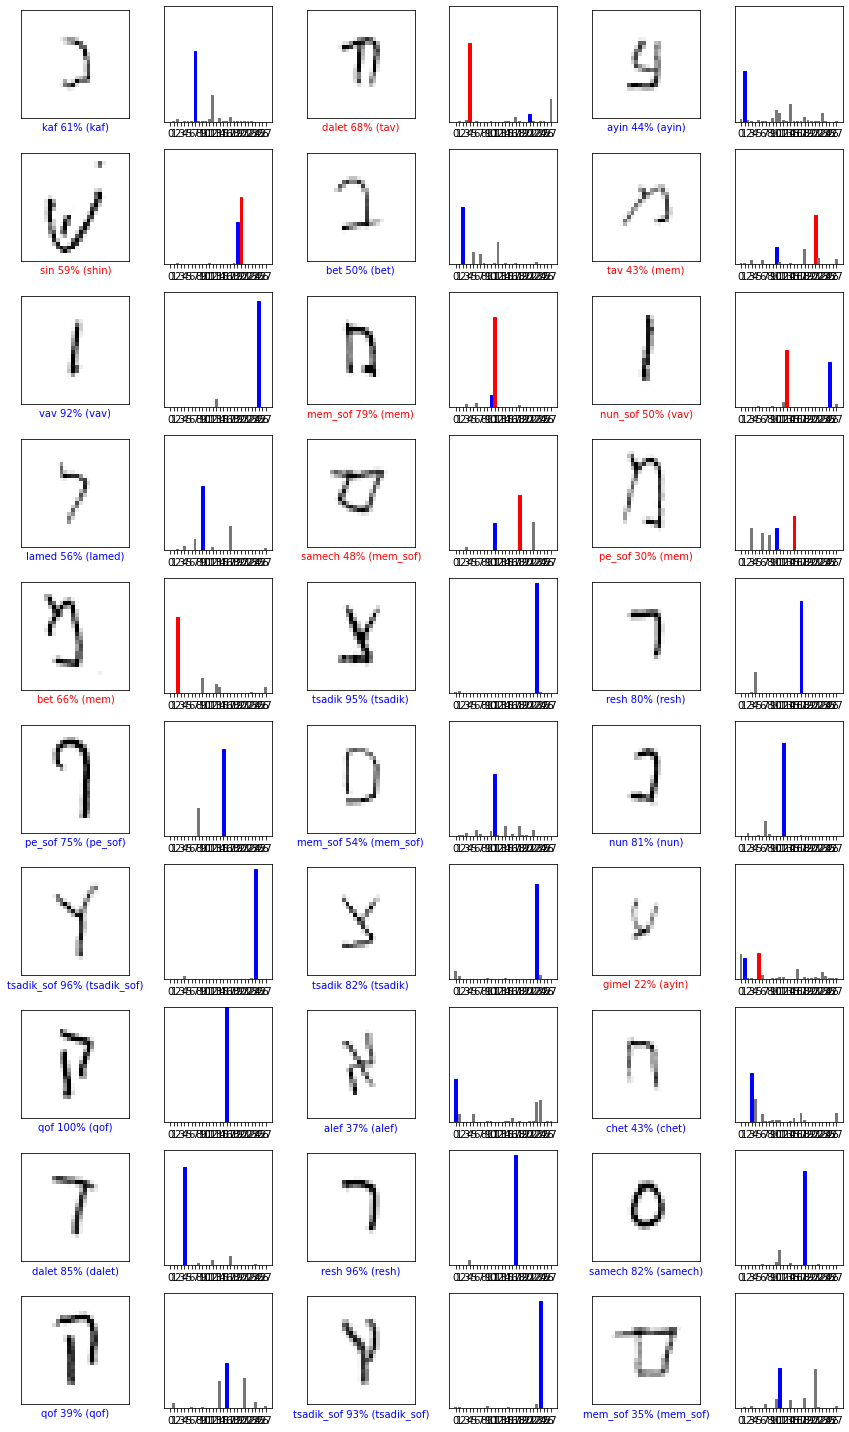

In [855]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [856]:
img = test_images[1]
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))
predictions_single = probability_model.predict(img)
# print(predictions_single)

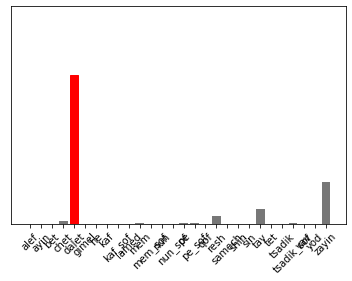

In [857]:
plot_value_array(200, predictions_single[0], test_labels)
_ = plt.xticks(range(NEW_SIZE), class_names, rotation=45)
plt.show()